# Machine Learning Engineering
# Project - stage I
**Authors:**
- Marcin Grabysz
- Aleksandra Jamróz

**Task**

Our song database is quite rich - they are described by many interesting parameters. Why nobody tagged if they are in major or minor scale so far? We have to change it!

**Business problem definition**

Problem we encounter is lack of labelling whether tracks in our's client database are in minor or major scale. 

**Definition of modeling task**

Our task is to classify the tracks using provided parameters. 

**Success criteria**

Our goal is to reach around 70% accuracy of prediction. This number is similar to one obtained by our baseline test, but as long as we are young company, we don't want to overestimate our possibilities. After analysing the data, we believe we have enough information to create a satisfying product. All the analysys can be found below.

**Domain analysis**

In classical European music, the tonality (key) of a piece determines the choice of seven from among the twelve notes of the chromatic scale. The mode (major/minor) of a piece, in simpler terms, tells you around which notes of the seven-note scale obtained in such way the melody oscillates and which chords cause the tension and its resolution - in even simpler words, whether the piece is dominated by minor or major chords.

In the perception of a piece, usually pieces in the major mode are considered positive and joyful, while pieces in the minor mode are considered sad or melancholy.

# Data analysis 

Analysis concerns dataset version 1. and version 2.

## Table "Tracks" 

Task concerns defining one of track's characteristic, which is mode (major or minor), therefore we expect most relevant data to be found in "tracks" table

In [1]:
import great_expectations as gx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_json("IUM23L_Zad_08_03_v1/tracks.jsonl", lines=True)
df_v2 = pd.read_json("IUM23L_Zad_08_03_v2/tracks.jsonl", lines=True)

gdf_v2 = gx.from_pandas(df_v2)

### General information about "Tracks" table

#### Conclusions
* improvement in data quality (in respect to v1) - columns id, name and popularity do not contain null values no more
* parameters description was not provided - therefore below we'll present a description from https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features 
* column "mode" appeared in the table, although it contains null value in majority of rows 

In [3]:
# first version

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129648 entries, 0 to 129647
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                103587 non-null  object 
 1   name              103775 non-null  object 
 2   popularity        103772 non-null  float64
 3   duration_ms       129648 non-null  int64  
 4   explicit          129648 non-null  int64  
 5   id_artist         103849 non-null  object 
 6   release_date      129648 non-null  object 
 7   danceability      129648 non-null  float64
 8   energy            129648 non-null  float64
 9   key               129648 non-null  int64  
 10  loudness          129648 non-null  float64
 11  speechiness       129648 non-null  float64
 12  acousticness      129648 non-null  float64
 13  instrumentalness  129648 non-null  float64
 14  liveness          129648 non-null  float64
 15  valence           129648 non-null  float64
 16  tempo             12

In [4]:
# second version

df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129648 entries, 0 to 129647
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                129648 non-null  object 
 1   name              129648 non-null  object 
 2   popularity        129648 non-null  int64  
 3   duration_ms       129648 non-null  int64  
 4   explicit          129648 non-null  int64  
 5   id_artist         129648 non-null  object 
 6   release_date      129648 non-null  object 
 7   danceability      129648 non-null  float64
 8   energy            129648 non-null  float64
 9   key               129648 non-null  int64  
 10  mode              25929 non-null   float64
 11  loudness          129648 non-null  float64
 12  speechiness       129648 non-null  float64
 13  acousticness      129648 non-null  float64
 14  instrumentalness  129648 non-null  float64
 15  liveness          129648 non-null  float64
 16  valence           12

#### Parameters description
https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

* **id** \
string \
The Spotify ID for the track \
Example value: "2takcwOaAZWiXQijPHIx7B"

* **name** \
string \
The title of the track (supposedly)
Example value: "Wie weit wir gehen"

* **popularity** \
integer \
The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

* **duration_ms** \
integer \
The duration of the track in milliseconds. \
Example value: 237040 

* **explicit** \
Whether or not the track has explicit lyrics \
( true = yes it does; false = no it does not OR unknown).

* **id_artist** \
string \
Id of the artist \

* **release_date** \
date \
Release date \
Example value: "2011-06-10"

* **danceability** \
number [float] \
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. \
Example value: 0.585 

* **energy** \
number [float] \
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. \
Example value: 0.842

* **key**
integer \
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. \
Example value: 9 \
Range: -1 - 11

* **mode** \
integer \
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. \
Example value: 0

* **loudness** \
number [float] \
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db. \
Example value: -5.883

* **speechiness** \
number [float] \
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. \
Example value: 0.0556

* **acousticness** \
number [float] \
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. \
Example value: 0.00242 \
Range: 0 - 1

* **instrumentalness** \
number [float] \
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. \\
Example value: 0.00686

* **liveness** \
number [float] \
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. \
Example value: 0.0866 

* **valence** \
number [float] \
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). \
Example value: 0.428 \
Range: 0 - 1

* **tempo** \
number [float] \
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. \
Example value: 118.211 

* **time_signature** \
integer \
An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". \
Example value: 4 \
Range: 3 - 7

### Uniqueness of columns


In [5]:
# After update of the data none of the id is duplicated and none of them is null. Great!

gdf_v2.expect_column_values_to_be_unique("id")

{
  "result": {
    "element_count": 129648,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": true,
  "meta": {}
}

In [6]:
# We should not be happy too soon, though. We assume that two records with the same name and artist are indeed the
# same song (artists rarely use the same title twice). We found more than 10 thousand of such duplications, which
# should be removed, as they do not bring any value to the dataset

gdf_v2.expect_compound_columns_to_be_unique(("name", "id_artist"))

{
  "result": {
    "element_count": 129648,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 10133,
    "unexpected_percent": 7.815778106873997,
    "unexpected_percent_total": 7.815778106873997,
    "unexpected_percent_nonmissing": 7.815778106873997,
    "partial_unexpected_list": [
      {
        "name": "Young Turks",
        "id_artist": "2y8Jo9CKhJvtfeKOsYzRdT"
      },
      {
        "name": "Il venait d'avoir 18 ans - French Version",
        "id_artist": "04aQfpx1U1WQEJkrvGs4ig"
      },
      {
        "name": "Luglio",
        "id_artist": "26YwzAEW3kihviypkZpOfq"
      },
      {
        "name": "The A Team",
        "id_artist": "6eUKZXaKkcviH0Ku9w2n3V"
      },
      {
        "name": "Chaleco Salvavidas",
        "id_artist": "49EE6lVLgU8sp7dFgPshgM"
      },
      {
        "name": "Sorry",
        "id_artist": "1uNFoZAHBGtllmzznpCI3s"
      },
      {
        "name": "\u0e02\u0e2d\u0e1a\u0e43\u0e08\u0e08\u0e23\u0e34\u0e07 \u0e46",
        "

In [7]:
# Drop duplicated songs and repeat check

df_v2.drop_duplicates(subset=("name", "id_artist"), inplace=True)
gdf_v2 = gx.from_pandas(df_v2)
gdf_v2.expect_compound_columns_to_be_unique(("name", "id_artist"))

{
  "result": {
    "element_count": 124236,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "success": true,
  "meta": {}
}

### Correlation

Correlation of the parameters is presented in the table below - it is possible to distinguish some higly correlated pairs (these connections are quite constistent with how we intuitively understand meaning of these parameters): *energy*-*loudness*, *danceability*-*valence*; as well as a few pairs with a noticeable negative correlation: *energy*-*acousticness*, *loudness*-*acousticness*.

<Axes: >

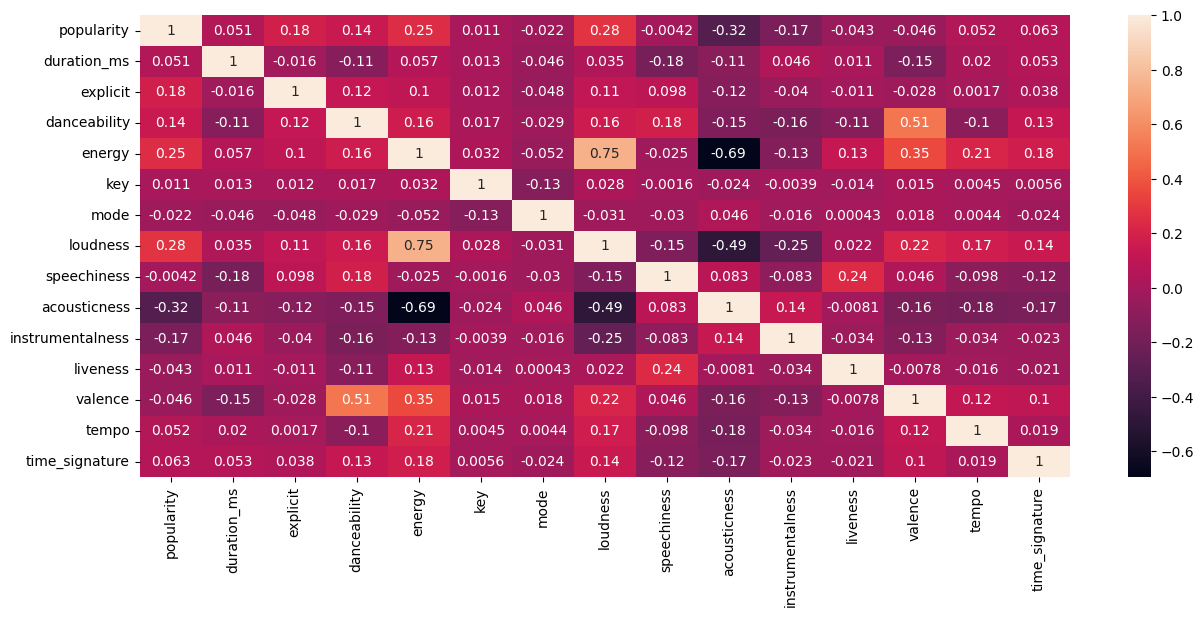

In [8]:
correlation_matrix = df_v2.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True)

### Analysis of distribution

Graphs representing distribution of some parameters are shown below. A few characteristics have to be taken into consideration:

* Parameters ranges are extremely various - some limit to a range of (0-1) and some extend from 0 to 100. Normalisation should be considered.
* Parameter "key" should not be considered as a numeric value and to make it visible on the histogram its value is mapped to the letter (American) notation. **It should not be thought as** parameter which values can be compared in a linear way - this means that D key **is not** any greater than C key, it's just a different choice of tones. To use this parameter in any model it should be mapped to one-hot encoding eventually.
* There is twice more tracks in major mode than in minor one - this can be potencially dangerous, as mode is the parameter we want to classify.
* Parameter "loudness" has (by nature of dB) logaritmical distribution and negative values. Normalisation should be considered.
* According to description of parameter "speechiness", for musical tracks this parameters most likely assumes values below 0.33 (above are spoken or semi-spoken tracks like podcasts, talk shows or rap). Mode applies only to musical compositions, so any tracks with speechiness above this level should be cut off (luckily, huge majority of the tracks is located below this threshold).


In [9]:
# Change output window size to display whole histogram
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

'popularity'

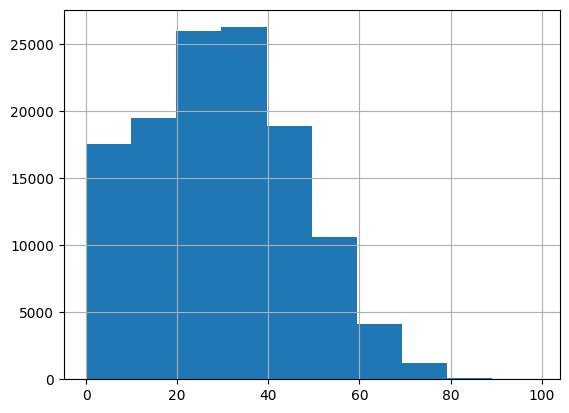

'danceability'

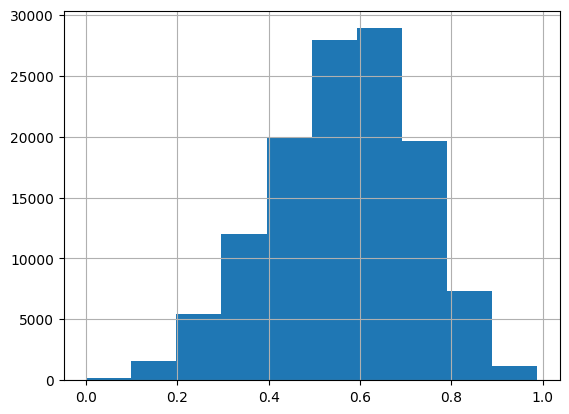

'energy'

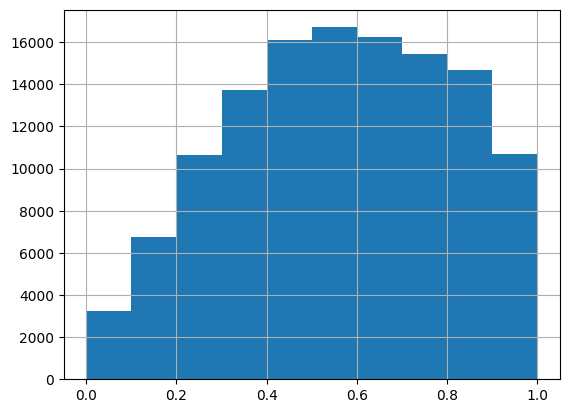

'mode'

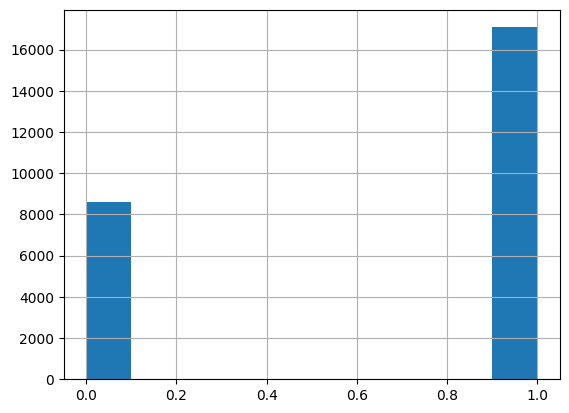

'loudness'

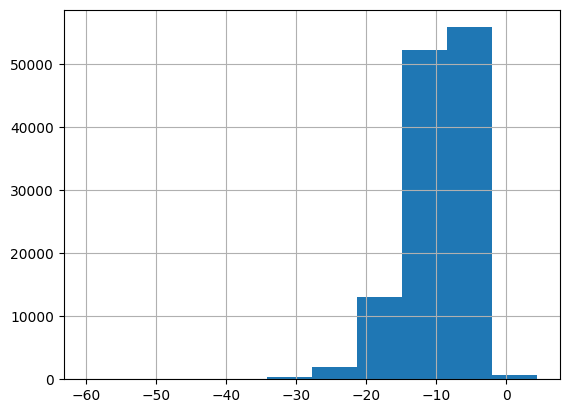

'speechiness'

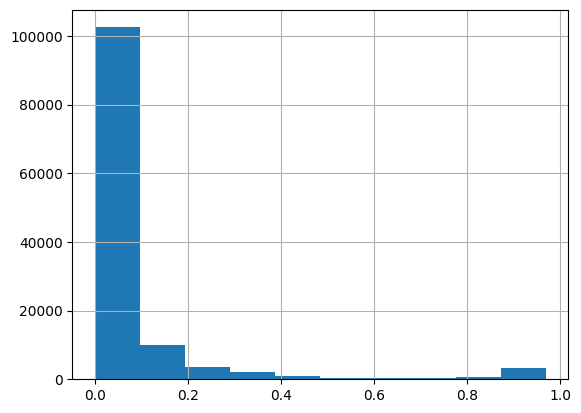

'acousticness'

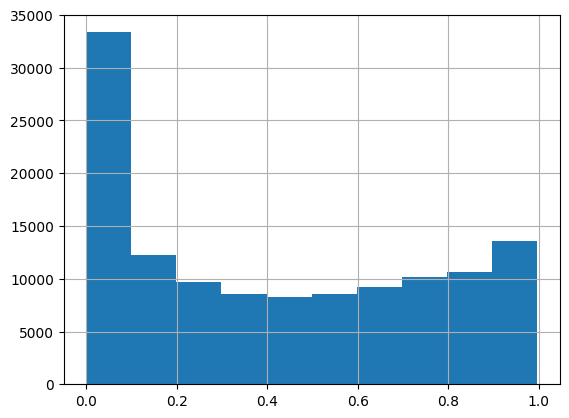

'instrumentalness'

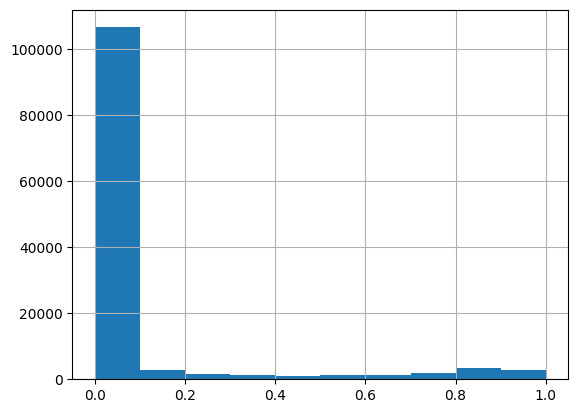

'liveness'

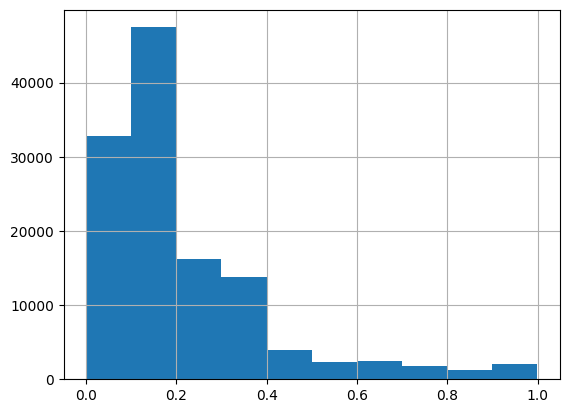

'valence'

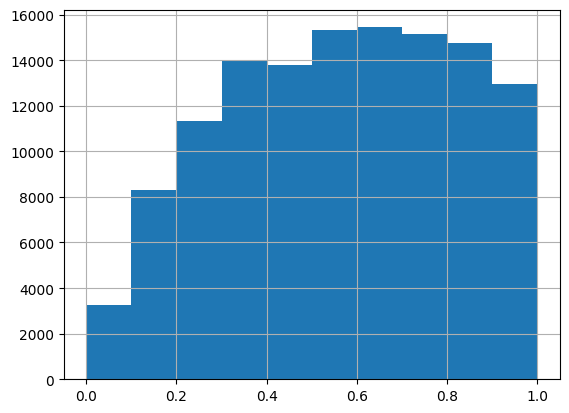

'tempo'

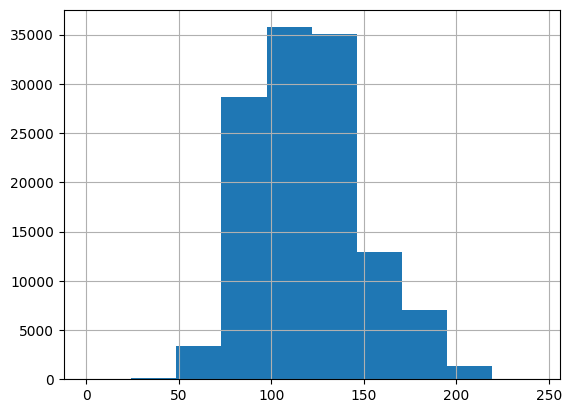

'key'

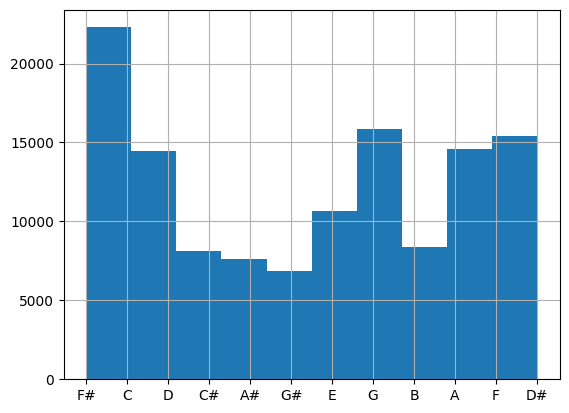

In [19]:
for name in [
    "popularity",
    "danceability",
    "energy",
    "mode",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]:
    display(name)
    column = df_v2[name]
    column.hist()
    plt.show()

# "key" column requires small change
name = "key"
display(name)
column = df_v2[name].replace({0: "C", 1: "C#", 2: "D", 3: "D#", 4: "E", 5: "F", 6: "F#", 7: "G", 8: "G#", 9: "A", 10: "A#", 11: "B"})
column.hist()
plt.show()


### Basic classification model

For measuring the baseline, we did a little test with a popular model. Second batch of data looked promising, but we still can't be sure what results should we expect. Test below was run with little preparation, was not adjusted and created with our intuition. As long as xgboost is a really good model, we don't expect our solution to work much better.

### Steps:
    1. Choosing rows with mode label existing
    2. Dropping intuitivly unnecessary columns
    3. Scaling the data
    4. Dividing it into training and testing datasets
    5. Fitting an Xgboost model to training data
    6. Calculating accuracy based on predictions on testing data


In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

In [12]:
# choosing rows and columns

final_df = df_v2.loc[df_v2['mode'].notnull()]
final_df = final_df.drop(columns=["id", "name", "popularity", "explicit", "duration_ms", "id_artist", "release_date"])
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25688 entries, 0 to 25928
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      25688 non-null  float64
 1   energy            25688 non-null  float64
 2   key               25688 non-null  int64  
 3   mode              25688 non-null  float64
 4   loudness          25688 non-null  float64
 5   speechiness       25688 non-null  float64
 6   acousticness      25688 non-null  float64
 7   instrumentalness  25688 non-null  float64
 8   liveness          25688 non-null  float64
 9   valence           25688 non-null  float64
 10  tempo             25688 non-null  float64
 11  time_signature    25688 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 2.5 MB


In [13]:
# dividing into X and y 

X_final = final_df.drop(columns=["mode"])
y_final = final_df["mode"]

In [14]:
# scaling the data and train test split

scaler = StandardScaler()
scaler.fit(X_final)
X_scaled = scaler.transform(X_final)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_final, test_size=0.2, random_state=42)

In [15]:
# fitting a model

xgb_tree = xgb.XGBClassifier()
xgb_tree.fit(X_train, y_train)
pred = xgb_tree.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy: ", round(acc*100, 4), "%")

Accuracy:  69.1125 %


Based on that test, we estimate our final result to be around 70% accuracy.

## Appendix - previous analysys (before obtaining data v2)

***Note**: this fragment contains part of analysis regarding the first set of data (without the `mode` column) and is no longer relevant; however, we decided to put it in the document to demonstrate what ideas we had (which we have eventually rejected) and how our thinking about the problem has evolved.*

### Domain analysis

In classical European music, the tonality (key) of a piece determines the choice of seven from among the twelve notes of the chromatic scale. The mode (major/minor) of a piece, in simpler terms, tells you around which notes of the seven-note scale thus obtained the melody oscillates and which chords cause the tension and its resolution - in even simpler words, whether the piece is dominated by minor or major chords.

In the perception of a piece, usually pieces in the major mode are considered positive and joyful, while pieces in the minor mode are considered sad or melancholy. The verbal description of this phenomenon seems to correspond closely to the description of the `valence` attribute:

```
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
```

In the absence of any test set with a correctly defined mode value, one suggestion might be to use the `valence` attribute as a classification object - for the end user, the "mood" of a track is a more telling feature than the theoretical "mode"


#### Hypothesis about the dependence of the character of the track on the key

In theory, the choice of key does not determine the mode (a piece can be in C major as well as C minor), however, in practice, for some instrumentalists, certain keys are simpler than others (for example, it is simpler to play in C major than in C minor - in the former, the pianist uses only white keys, while in the latter - as many as three black keys). For this reason, the hypothesis was formed that for the key of C, major pieces should have an advantage, i.e. the average `valence` should be high. In contrast, in the key of A, for example, it is easier to play the minor scale than the major scale, and therefore the expected `valence` should be low.

However, the hypothesis collapsed. The table below shows the average value of `valence` for each key - you can see that tonality has almost no effect on `valence`.

In [20]:
df_v2["key"].replace({0: "C", 1: "C#", 2: "D", 3: "D#", 4: "E", 5: "F", 6: "F#", 7: "G", 8: "G#", 9: "A", 10: "A#", 11: "B"},
          inplace=True)
df_v2.groupby(["key"]).mean()["valence"]

key
A     0.573110
A#    0.566815
B     0.569903
C     0.567508
C#    0.553466
D     0.558046
D#    0.536177
E     0.548732
F     0.574514
F#    0.561795
G     0.566929
G#    0.560583
Name: valence, dtype: float64

The study may be affected by the fact that some tones (key) occur more often than others:

In [23]:
df_v2.groupby(["key"]).size().sort_values(ascending=False)

key
C     15966
G     15829
A     14612
D     14469
F     11182
E     10630
B      8385
C#     8149
A#     7595
G#     6881
F#     6332
D#     4206
dtype: int64

In [22]:
# after obtaining the data v2 with "mode" column we made the check and our intuition was partially right
# the major mode dominates in keys in which it's simple to play in major, like: C, G
# the minor mode dominates in keys in which it's simple to play in minor, like: A, E
# however, the results are biased anyway by the fact that tracks in major mode 
# are twice more frequent in the dataset 

def get_keys_mode_df():
    keys_dict = {}
    for index, row in df_v2[["key", "mode"]].iterrows():
        if row["key"] not in keys_dict.keys():
            keys_dict[row["key"]] = {"major": 0, "minor": 0}
        if row["mode"] == 0:
            keys_dict[row["key"]]["minor"] += 1
        if row["mode"] == 1:
            keys_dict[row["key"]]["major"] += 1
    return pd.DataFrame.from_dict(keys_dict)

get_keys_mode_df()

,F#,C,D,C#,A#,G#,E,G,B,A,F,D#
major,616,2630,2252,1182,938,1162,1081,2552,681,1918,1418,653
minor,639,691,722,539,592,287,1135,724,1021,1169,852,234
